# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.decomposition import PCA

# import data
from worclipo.load_data import load_data

## Functions to split the data

In [2]:
# function to split the dataset into train and test
def split_set(X,y,test_size):

    if os.path.exists('./TEST_set.csv'):
        split_action = print('TEST_set.csv already exists')
    else:
        split_action = print('TEST_set.csv does not exist, generating new test and training sets')
        X_train_csv, X_test_csv, y_train_csv, y_test_csv = train_test_split(X, y, test_size=test_size, random_state=10)

        TESTSET = X_test_csv.merge(y_test_csv, left_index=True, right_index=True)
        TESTSET.to_csv('TEST_set.csv')

        TRAINSET = X_train_csv.merge(y_train_csv, left_index=True, right_index=True)
        TRAINSET.to_csv('TRAIN_set.csv')
        return split_action

## Setting up the data to be processed

In [3]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(type(data))

# change lipoma = 1 and liposarcoma = 0 and encode labels
group_names = list(set(data.label))
data.loc[data['label'] == 'lipoma', 'label'] = 1
data.loc[data['label'] == 'liposarcoma', 'label'] = 0
data['label'] = pd.cut(data['label'], bins = 2, labels=group_names)
print(data['label'].unique())
label_diag = LabelEncoder()
data['label'] = label_diag.fit_transform(data['label'])

# assign X to measurements and y to outcome (lipoma/sarcoma)
X = data.drop('label', axis=1)
y = data['label']
test_size = 0.3

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
['lipoma', 'liposarcoma']
Categories (2, object): ['lipoma' < 'liposarcoma']


In [4]:
# code that splits the data into test and validation sets if this is not done already
split_set(X,y,test_size)

TEST_set.csv already exists


## Import the training set

In [5]:
# import
TRAIN = pd.read_csv('TRAIN_set.csv', index_col=0)
X_train = TRAIN.drop('label', axis=1)
y_train = TRAIN['label']

TRAIN['label'] = pd.cut(TRAIN['label'], bins = 2, labels=group_names)
print(TRAIN['label'].unique())
label_diag = LabelEncoder()
TRAIN['label'] = label_diag.fit_transform(TRAIN['label'])

# split into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=10)

print(f'Size before preprocess: ', X_train.shape)


['lipoma', 'liposarcoma']
Categories (2, object): ['lipoma' < 'liposarcoma']
Size before preprocess:  (56, 493)


## Gridsearch for best classifiers

In [6]:
N_FEATURES_OPTIONS = [15, 18, 19, 20, 22, 25]

# set up pipeline steps
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
variance = VarianceThreshold(threshold=0)
pca = PCA()

# set up classifiers
clf1 = RandomForestClassifier(random_state=1)
clf2 = SVC(probability=True, random_state=1, max_iter=1000)
clf3 = LogisticRegression(random_state=1)
clf4 = DecisionTreeClassifier(random_state=1)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()

pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('variance', variance), ('pca', pca), ('classifier', clf2)])

# set up parameters
param1 = {}
param1['classifier__n_estimators'] = [1,10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['pca__n_components'] = N_FEATURES_OPTIONS
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [0.1, 1, 10, 100]
param2['classifier__class_weight'] = [None]
param2['classifier__kernel'] = ['sigmoid']
param2['pca__n_components'] = N_FEATURES_OPTIONS
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = [None, 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}]
param3['pca__n_components'] = N_FEATURES_OPTIONS
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}]
param4['pca__n_components'] = N_FEATURES_OPTIONS
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['pca__n_components'] = N_FEATURES_OPTIONS
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['pca__n_components'] = N_FEATURES_OPTIONS
param6['classifier'] = [clf6]

param_grid = [param1, param2, param3, param4, param5, param6]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

# Test data performance
print("Test Precision:",precision_score(grid.predict(X_valid), y_valid))
print("Test Recall:",recall_score(grid.predict(X_valid), y_valid))
print("Test ROC AUC Score:",roc_auc_score(grid.predict(X_valid), y_valid))

best_clf = grid.best_estimator_
best_clf.fit(X_train,y_train)
pred_rfc = best_clf.predict(X_valid)

print('rfc', classification_report(y_valid, pred_rfc))
print(confusion_matrix(y_valid, pred_rfc))

results = pd.DataFrame(grid.cv_results_)
results = results.sort_values(by=['rank_test_score'])
results.to_csv('results')

c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\kiki6\miniconda3\lib\site-packages\sklearn\naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "c:\Users\kiki6\miniconda3\lib\

{'classifier': SVC(C=10, kernel='sigmoid', max_iter=1000, probability=True, random_state=1), 'classifier__C': 10, 'classifier__class_weight': None, 'classifier__kernel': 'sigmoid', 'pca__n_components': 19}
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0)),
                ('pca', PCA(n_components=19)),
                ('classifier',
                 SVC(C=10, kernel='sigmoid', max_iter=1000, probability=True,
                     random_state=1))])
0.7303030303030302
Test Precision: 0.6153846153846154
Test Recall: 0.8888888888888888
Test ROC AUC Score: 0.7777777777777778
rfc               precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.89      0.62      0.73        13

    accuracy                           0.75        24
   macro avg       0.78      0.76      0.75        24
weighted avg       0.79   

### Cross Validation KFold selection 

The best k-fold value for LogisticRegression is 3 with a mean accuracy of 0.553
The best k-fold value for DecisionTreeClassifier is 5 with a mean accuracy of 0.591
The best k-fold value for RandomForestClassifier is 7 with a mean accuracy of 0.661
The best k-fold value for KNeighborsClassifier is 6 with a mean accuracy of 0.569
The best k-fold value for SVC is 4 with a mean accuracy of 0.536


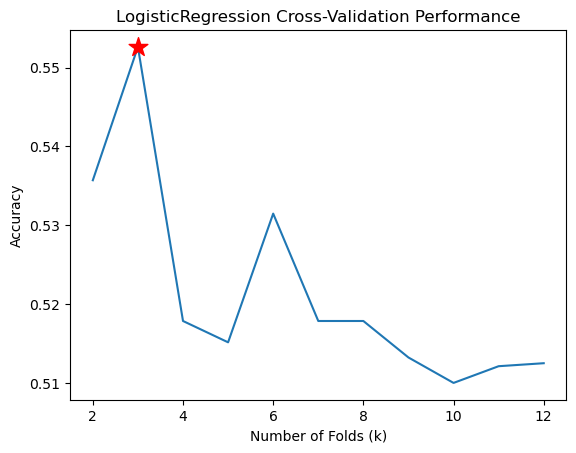

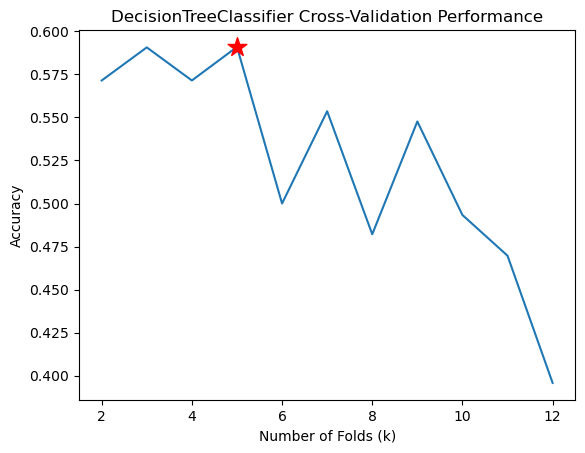

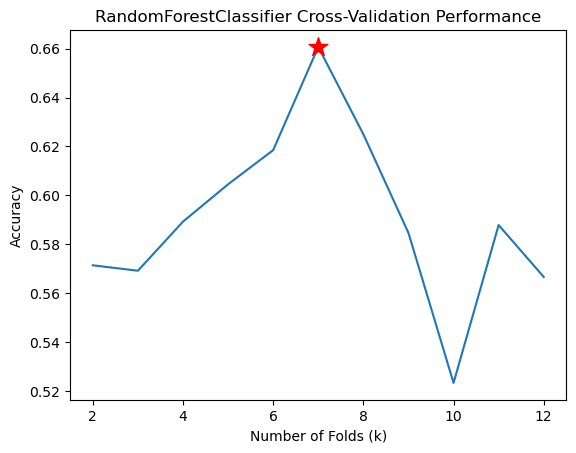

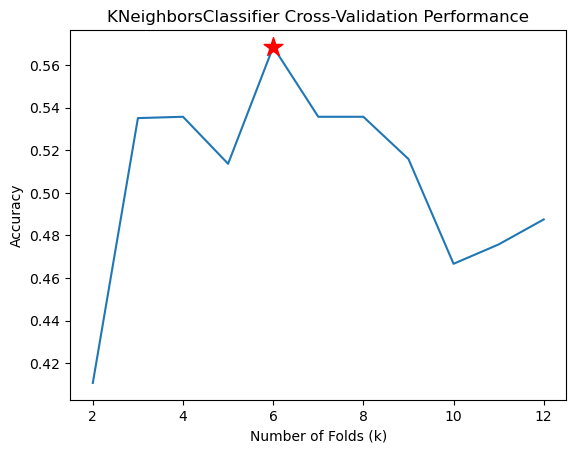

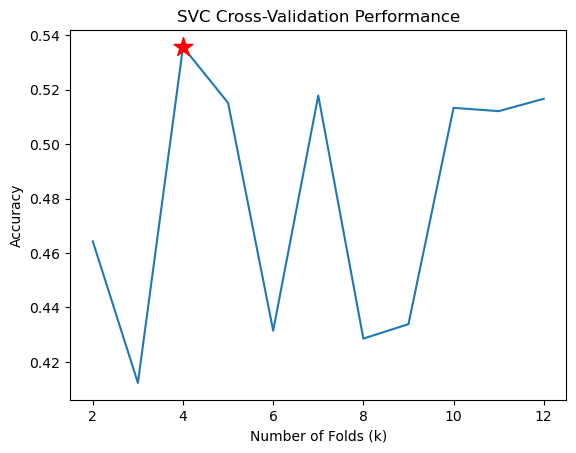

In [7]:
# Trying differen K folds in cross validation per classifier
# Used to give us an idea on which Kfold to use

# function
def perform_cross_validation(clf, k_values, X_train, y_train):
    best_k = None
    best_score = None
    results = []
    for k in k_values:
        kf = KFold(n_splits=k, shuffle=True, random_state=10)
        scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
        mean_score = np.mean(scores)
        results.append((k, scores))
        if best_score is None or mean_score > best_score:
            best_k = k
            best_score = mean_score
    return best_k, results

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC()
]

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

best_k_values = {}
results = []

for clf in classifiers:
    clf_name = type(clf).__name__
    best_k, cv_results = perform_cross_validation(clf, k_values, X_train, y_train)
    best_k_values[clf_name] = best_k
    results.append((clf_name, cv_results))
    print(f"The best k-fold value for {clf_name} is {best_k} with a mean accuracy of {np.max([np.mean(cv_scores) for _, cv_scores in cv_results]):.3f}")

for clf_name, cv_results in results:
    fig, ax = plt.subplots()
    scores = [np.mean(cv_scores) for _, cv_scores in cv_results]
    ax.plot(k_values, scores)
    ax.scatter(best_k_values[clf_name], np.max(scores), marker='*', s=200, color='r', zorder=10)
    ax.set_xlabel('Number of Folds (k)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{clf_name} Cross-Validation Performance')
    plt.show()

## Number of features

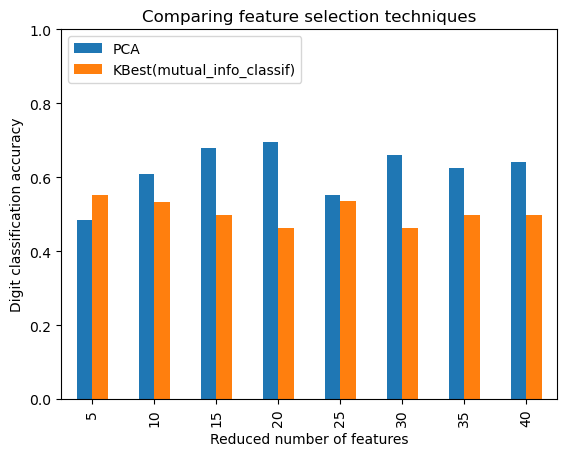

In [8]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('reduce_dim', 'passthrough'),
    ('classify', SVC(kernel='sigmoid', max_iter=1000))
])

N_FEATURES_OPTIONS = [5, 10, 15, 20, 25, 30, 35, 40]
C_OPTIONS = [10]
param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(mutual_info_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'KBest(mutual_info_classif)']

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature selection techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()

## Optimize the best estimator from the gridsearch

In [9]:
pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('variance', variance), ('pca', pca), ('classifier', SVC(probability=True, random_state=8, max_iter=1000))])

param_grid = {}
param_grid['classifier__C'] = [v for v in np.linspace(1,100,100)]
param_grid['classifier__class_weight'] = [None]
param_grid['classifier__kernel'] = ['linear', 'rbf', 'poly', 'sigmoid']
param_grid['pca__n_components'] = [19]

gsb = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, scoring='accuracy')
gsb.fit(X_train, y_train)
print(gsb.best_params_)
print(gsb.best_estimator_)
print(gsb.best_score_)

best_clf = gsb.best_estimator_
best_clf.fit(X_train,y_train)
pred_rfc = best_clf.predict(X_valid)

print('rfc', classification_report(y_valid, pred_rfc))
print(confusion_matrix(y_valid, pred_rfc))

results = pd.DataFrame(gsb.cv_results_)
results = results.sort_values(by=['rank_test_score'])
results.to_csv('results')

print("Test Precision:",precision_score(gsb.predict(X_valid), y_valid))
print("Test Recall:",recall_score(gsb.predict(X_valid), y_valid))
print("Test ROC AUC Score:",roc_auc_score(gsb.predict(X_valid), y_valid))

{'classifier__C': 5.0, 'classifier__class_weight': None, 'classifier__kernel': 'sigmoid', 'pca__n_components': 19}
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0)),
                ('pca', PCA(n_components=19)),
                ('classifier',
                 SVC(C=5.0, kernel='sigmoid', max_iter=1000, probability=True,
                     random_state=8))])
0.7515151515151515
rfc               precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.82      0.69      0.75        13

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24

[[9 2]
 [4 9]]
Test Precision: 0.6923076923076923
Test Recall: 0.8181818181818182
Test ROC AUC Score: 0.7552447552447552


## Run classifier on test set

In [10]:
# import the test set
TEST = pd.read_csv('TEST_set.csv', index_col=0)
X_test = TEST.drop('label', axis=1)
y_test = TEST['label']

TEST['label'] = pd.cut(TEST['label'], bins = 2, labels=group_names)
label_diag = LabelEncoder()
TEST['label'] = label_diag.fit_transform(TEST['label'])

# predict
pred_test = best_clf.predict(X_test)

# results 
print('Test classification report \n', classification_report(y_test, pred_test))
print("Test Precision:    ",precision_score(gsb.predict(X_test), y_test))
print("Test Recall:       ",recall_score(gsb.predict(X_test), y_test))
print("Test ROC AUC Score:",roc_auc_score(gsb.predict(X_test), y_test))
 
print('confusion matrix \n', confusion_matrix(y_test, pred_test))

Test classification report 
               precision    recall  f1-score   support

           0       0.58      0.82      0.68        17
           1       0.73      0.44      0.55        18

    accuracy                           0.63        35
   macro avg       0.66      0.63      0.62        35
weighted avg       0.66      0.63      0.62        35

Test Precision:     0.4444444444444444
Test Recall:        0.7272727272727273
Test ROC AUC Score: 0.6553030303030303
confusion matrix 
 [[14  3]
 [10  8]]


## ROC curve

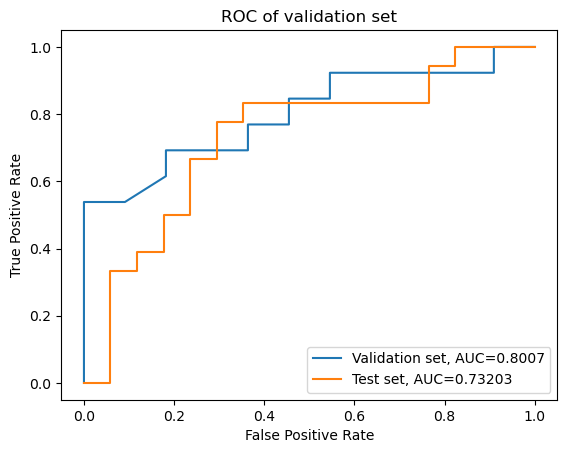

In [11]:
pred_val = best_clf.predict_proba(X_valid)[:,1]

fpr_val, tpr_val, _ = metrics.roc_curve(y_valid, pred_val)
auc_val = metrics.roc_auc_score(y_valid, pred_val)

pred_test = best_clf.predict_proba(X_test)[:,1]

fpr_test, tpr_test, _ = metrics.roc_curve(y_test, pred_test)
auc_test = metrics.roc_auc_score(y_test, pred_test)

plt.plot(fpr_val,tpr_val,label="Validation set, AUC="+str(round(auc_val,5)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of validation set')
plt.legend(loc=4)

plt.plot(fpr_test,tpr_test,label="Test set, AUC="+str(round(auc_test,5)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Learning curve

Training set

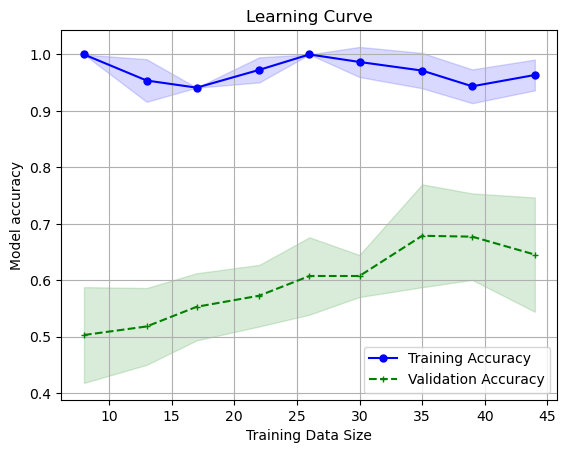

In [12]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Validation set

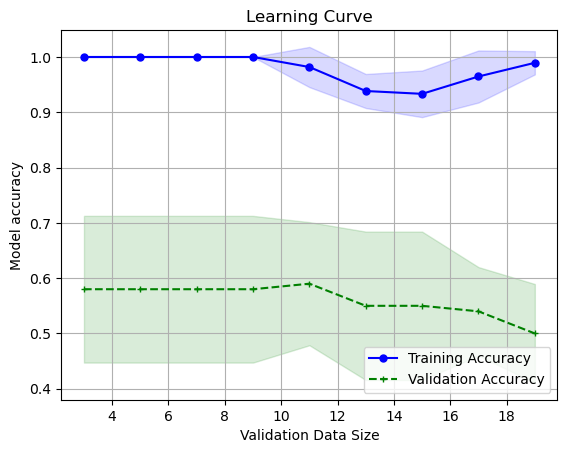

In [13]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_valid, y=y_valid,
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Validation Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Test set

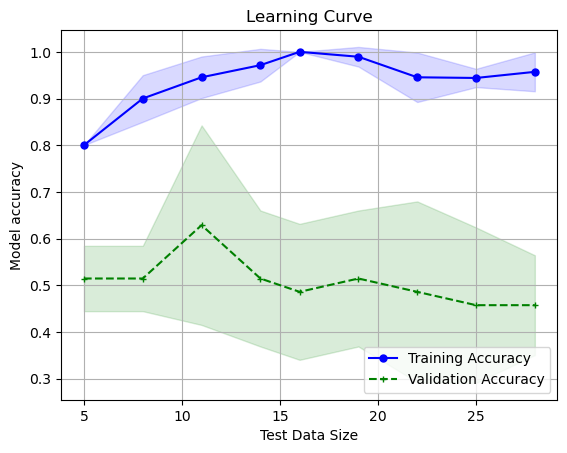

In [14]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_test, y=y_test,
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Test Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()